# Microsoft Movie Studio: A Romance to Make Millions

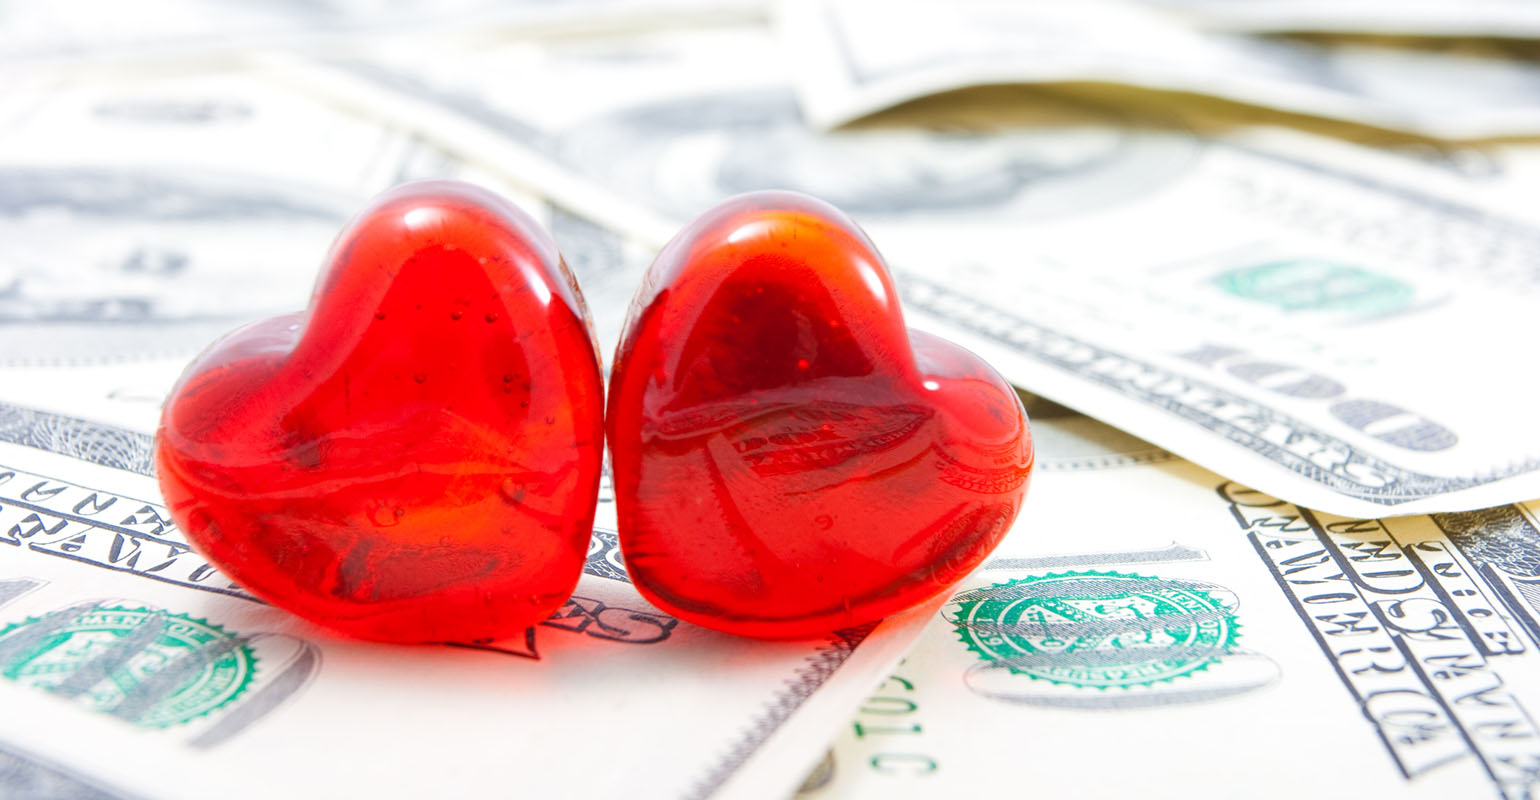

## The Business Problem

With a host of other tech giants getting in on the movie business, Microsoft wants get in on the action by creating a new movie studio. Since they are new to the game and know so little about the industry they have hired us to explore and analyze which movies are making the most at the box office. After some data wrangling and processing, we have settled on three major insights and deliverables! 

## The Solution?
Focusing on *return on investment, risk analysis of film budget tiers, and popular genres*, we suggest that Microsoft needs to 1) go big with its production budgets, 2) focus the majority of its budget on producing big "blockbuster" films, and 3) consider particular genres like drama and romance (at least according to this limited data set).

## Step 1: Data Understanding

We have settled on three main data repositories in order to make our case to Microsoft: Box Office Mojo (BOM), The Numbers (TN), and Rotten Tomatoes (RT). We chose both BOM and TN because of their broad inclusion of production budget and income numbers both domestically and worldwide. We ultimately focused primarily on budget and worldwide gross because the worldwide gross includes the domestic numbers as well. The RT data set was valuable for its inclusion of genres and ratings which allowed us to narrow down the types of films that seem to get the freshest (most valuable) reviews, in order to keep Microsoft as a "must-watch" studio. 

We begin by importing the proper tools and then the data itself.

In [1]:
#Import required tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sb
import datetime
import sqlite3
import warnings

#Adjustments
from matplotlib import rcParams
from scipy import stats
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Box office Mojo dataset
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv')

#The numbers datset
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv')

#Rotten Tomatoes dataset
rtin_df = pd.read_csv('zippedData/rt.movie_info.tsv', sep = '\t')
rtrv_df = pd.read_csv('zippedData/rt.reviews.tsv', delimiter = '\t', encoding = 'latin1')

## Step 2: Data Preperation

* In preparing the data, we knew we wanted to merge both BOM and TN in order to get the broadest possible set of gross income values for the domestic and worldwide releases in addition to production budgets. To help Microsoft know which movies make the most, we needed to make sure we had data on what movies were actually making (and costing!). And because the worldwide gross includes the domestic gross, we filled any missing worldwide rows with the same data from its partnered domestic column.

In [3]:
#Box Office Mojo: 

#Drop Unnecessary Columns
bom_df.drop(['studio'], axis=1, inplace=True)

#Clean years
bom_df['year'] = pd.to_datetime(bom_df['year'], format='%Y')
bom_df['year'] = pd.DatetimeIndex(bom_df['year']).year

#Rename Columns
bom_df.rename(columns={"foreign_gross": "worldwide_gross"}, inplace=True)

#Clean Budgets by Repalcing Nulls and Converting to Int
bom_df['worldwide_gross'] = bom_df['worldwide_gross'].fillna(bom_df['domestic_gross'])
bom_df['domestic_gross'] = bom_df['domestic_gross'].fillna(bom_df['worldwide_gross']).astype(np.int64)
bom_df['worldwide_gross'] = bom_df['worldwide_gross'].replace('[\,.]', '', regex=True).astype(np.int64)

In [4]:
#The Numbers: 

#Drop Unnecessary Columns
tn_df.drop(['id'], axis=1, inplace=True)

#Rename Columns
tn_df.rename(columns={"movie": "title", "release_date": "year"}, inplace=True)

#Clean years
tn_df["year"] = tn_df["year"].astype('datetime64[ns]')
tn_df['year'] = pd.to_datetime(tn_df['year'], format='%Y')
tn_df['year'] = pd.DatetimeIndex(tn_df['year']).year

#Clean Budgets, Drop Null Values, Convert to Int
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].fillna(0)
tn_df['domestic_gross'] = tn_df['domestic_gross'].fillna(0)
tn_df['production_budget'] = tn_df['production_budget'].replace('[\$,]', '', regex=True).astype(np.int64)
tn_df['domestic_gross'] = tn_df['domestic_gross'].replace('[\$,]', '', regex=True).astype(np.int64)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(np.int64)

* After cleaning, we merged the datasets and made sure the numbers appeared as intergers.

In [5]:
#Final merge and drop null values
fullframe = bom_df.merge(tn_df, how = 'outer')
fullframe = fullframe[fullframe['production_budget'].notna()]
fullframe.drop(fullframe.loc[fullframe['domestic_gross']==0].index, inplace=True)
fullframe['production_budget'] = fullframe['production_budget'].astype(np.int64)

* To avoid having to take inflation too much into account, we dropped films that were older than 20 years, and those whose budgets fall well below the "indie" film level as indicated by [Film Lifestyle](https://filmlifestyle.com/film-budgets/).

In [6]:
#Drop films older than 20 years and everything under the $10000 tier according to Film Lifestyle
fullframe = fullframe[fullframe.year > 1990]
fullframe = fullframe[fullframe.production_budget >= 10000]

#Drop Unnecessary Columns
fullframe.drop(['domestic_gross', 'year'], axis=1, inplace=True)

* With the RT data, we wanted to focus primarily on genre types and their critical review. While we would love to include the "box_office" numbers, there are just so few (340 out of 1559 entries) that any insights would be suspect.

In [7]:
#Rotten Tomatoes: 

#Drop Unnecessary Columns
rtrv_df.drop(['critic', 'rating', 'review', 'top_critic', 'publisher', 'date'], axis=1, inplace=True)
rtin_df.drop(['synopsis', 'dvd_date', 'currency', 'box_office', 'studio', 'director', 'writer', 'runtime', 'theater_date'], axis=1, inplace=True)

#Merge
rtmerge = rtin_df.merge(rtrv_df)

#Clean/Simplify Reviews by making them binary
rtmerge['critic_rating'] = rtmerge['fresh'].map({'fresh': 1, 'rotten': 0})
rtmerge.drop(['fresh'], axis=1, inplace=True)

#Fill empty cells with "other"
rtmerge['genre'] = rtmerge['genre'].fillna('other')

## Data Modeling

### First Insight: The relationship between "Production Budget" and "Gross Income"

* Our first intuition was to see what the actual return on investment was for production budgets. So we greated a profit column that subtracted the production budget from the overall (worldwide) gross. We then created a second column that calculated the retun on investment by dividing the profit by the production budget.

In [8]:
#create columns for profit and ROI
fullframe['profit'] = fullframe['worldwide_gross'] - fullframe['production_budget']
fullframe['ROI'] = fullframe['profit']/fullframe['production_budget']

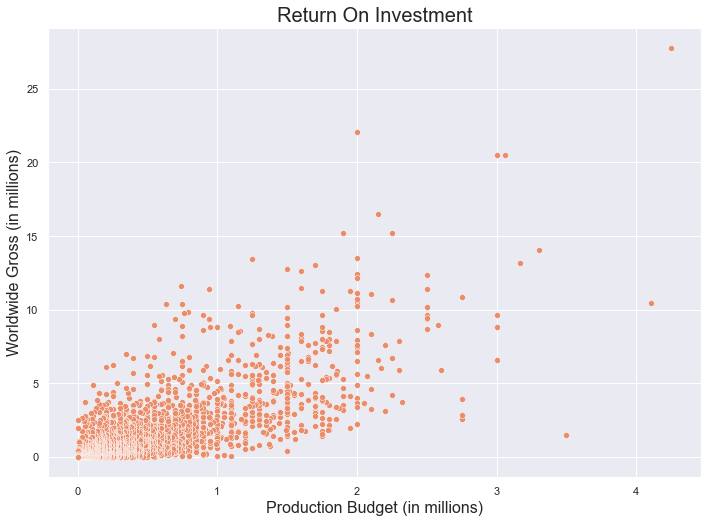

In [25]:
#ScatterPlot Budget and Worldwide Gross to see if there is any correlation
sb.set_palette("flare")
sb.scatterplot(fullframe['production_budget']/100000000, fullframe['worldwide_gross']/100000000).set_title('ROI')
plt.title('Return On Investment', fontsize=20)
plt.xlabel('Production Budget (in millions)', fontsize=16)
plt.ylabel('Worldwide Gross (in millions)', fontsize=16)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y');
sb.set(rc={'figure.figsize':(11.7,8.27)})

* At first glance, it seems like there is a pretty strong correlation between the amount of money a studio spends on a film and the amount of return they get. We wanted to pin this correlation down, so we turned our scatter plot into a regression plot, and then used scipy stats to create a line regression that could give us insight to how much actual return a studio would get per dollar spent.

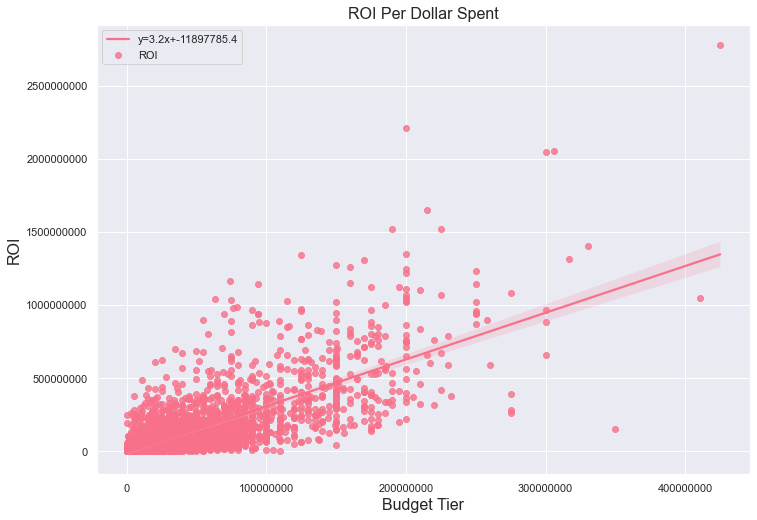

In [33]:
#A regression plot with dollar-value-additive of production investment:
slope, intercept, r_value, p_value, std_err = stats.linregress(fullframe['production_budget'],fullframe['worldwide_gross'])
sb.set_palette("husl", 9)
sb.regplot(x="production_budget", y="worldwide_gross", data=fullframe, label='ROI',
                line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)})
plt.title('ROI Per Dollar Spent', fontsize=16)
plt.xlabel('Budget Tier', fontsize=16)
plt.ylabel('ROI', fontsize=16)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y');
plt.legend();

* As it turns out, it looks like the studios can expect to get about 3 dollars back for every 1 dollar they add to their production budget. Not bad!

### Second Insight: Not all film budgets are created equal!

* But everyone knows that there are different tiers of films. Ranging from indie to blockbusters. So how do we take into account the budget tier of a film? We went to [Film Lifestyle](https://filmlifestyle.com/film-budgets/) in order to get a sense about what seperates the budgets of film tiers and then created a function to help us parse out the different film types we think Microsoft should be aiming for. We dropped the lowest tier of films (student films and others) that had budgets of less than $10000.

In [11]:
#Budget Tiers from Film Lifestyle
low_budget = range(10000, 249999)
moderate_budget = range(250000, 649999)
high_budget = range(650000, 1999999)
blockbuster_budget = range(2000000, 250000000)

In [34]:
#function to organize film tiers that iterates through each film's budget and than adds its budget tier to a new column.
def budget_tiers(x):
    if x in low_budget:
        return("Low Budget")
    elif x in moderate_budget:
        return("Moderate Budget")
    elif x in high_budget:
        return("High Budget")
    elif x >= 2000000:
        return("Blockbuster")
    else:
        return("N/A")

In [35]:
#create a new column that includes the budget tier
fullframe["budget_tier"] = fullframe["production_budget"].map(budget_tiers)

#Because the numbers are so large, they appear in scientific notation, so we have to remove that
pd.options.display.float_format = '{:.0f}'.format

#Use .groupby to see variables of budgets
fullframe.groupby('budget_tier').mean().sort_values("production_budget")

,worldwide_gross,production_budget,profit,ROI
budget_tier,,,,
Low Budget,1974333,107106,1867227,24
Moderate Budget,6852961,400991,6451970,14
High Budget,6870014,1188884,5681131,5
Blockbuster,116286290,40641891,75644399,2


* So according to our budget tier analysis, it looks like Microsoft should avoid Blockbusters and focus on low budget films! That doesn't seem right. Especially since our previous insight claimed that spending more money MADE more money. So we decided to dig a little deeper.

### Risk Assessment

In [36]:
#Sorting the values to look for deviations to measure potential risk
fullframe.groupby('budget_tier')["ROI"].describe().sort_values("budget_tier")

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
Blockbuster,4209,2,4,-1,-0,1,3,74
High Budget,244,5,13,-1,-1,0,4,101
Low Budget,85,24,67,-1,-1,2,11,416
Moderate Budget,111,14,59,-1,-1,0,4,431


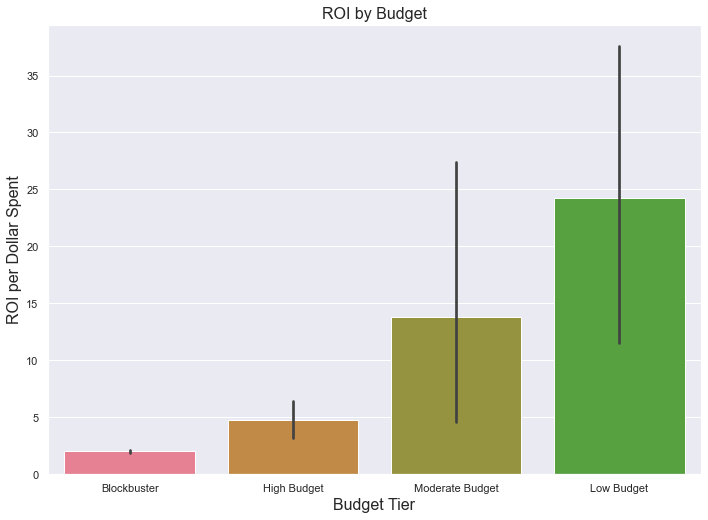

In [38]:
#Plotting ROI by budget tier
sb.barplot(data=fullframe, x='budget_tier',y="ROI")
plt.title('ROI by Budget', fontsize=16)
plt.xlabel('Budget Tier', fontsize=16)
plt.ylabel('ROI per Dollar Spent', fontsize=16)
plt.ticklabel_format(style='plain', axis='y');

* The above graph helps us see that while low budget films might offer the biggest return on investment, they also come with the highest deviation, which means they are VERY risky! But how risky?

## Calculating Financial Risk/Reward

In [40]:
#creating a dataframe to capture standard deviation
riskframe = fullframe.groupby('budget_tier')["ROI"].describe().sort_values("budget_tier")

In [41]:
#creating an djusted fullframe with a new "risk" column that measures how much each film deviated from the mean
fullframe_adj = fullframe.merge(riskframe['mean'], on='budget_tier')
fullframe_adj['risk'] = fullframe_adj['ROI'] - fullframe_adj['mean']
fullframe_adj.sample(5)

,title,worldwide_gross,production_budget,profit,ROI,budget_tier,mean,risk
3118,San qiang pai an jing qi,310946,12000000,-11689054,-1,Blockbuster,2,-3
1709,Safe,41495213,33000000,8495213,0,Blockbuster,2,-2
4301,Super Troopers,23046142,1200000,21846142,18,High Budget,5,13
2701,The Artist,128256712,16000000,112256712,7,Blockbuster,2,5
3370,Jab Tak Hai Jaan,5806666,9200000,-3393334,-0,Blockbuster,2,-2


In [42]:
#describe and sort values of new adjusted dataframe
fullframe_adj.groupby('budget_tier')["risk"].describe().sort_values("budget_tier")

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
Blockbuster,4209,0,4,-3,-2,-1,1,72
High Budget,244,0,13,-6,-6,-5,-0,96
Low Budget,85,-0,67,-25,-25,-22,-13,391
Moderate Budget,111,0,59,-15,-15,-14,-10,417


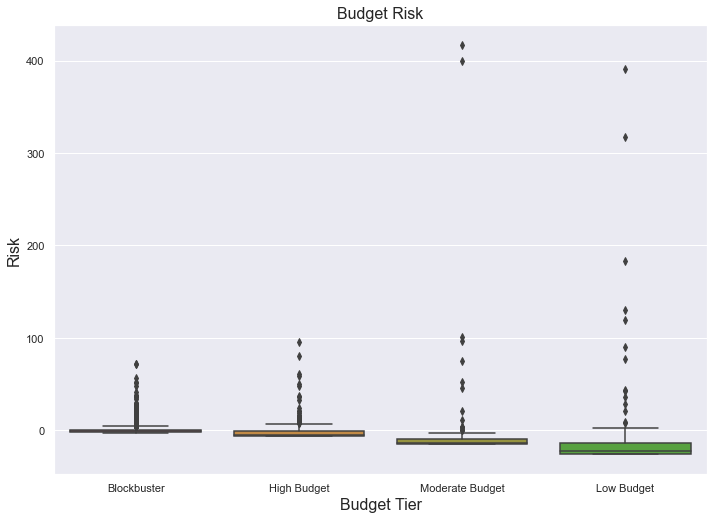

In [43]:
#plot risk adjusted frame 
sb.boxplot(data=fullframe_adj, x='budget_tier',y="risk");
plt.title('Budget Risk', fontsize=16)
plt.xlabel('Budget Tier', fontsize=16)
plt.ylabel('Risk', fontsize=16)
plt.ticklabel_format(style='plain', axis='y');

* The above graph is hard to read because the outliers are so great. Both moderate and low budget films seem to have the possibility to produce a ridiculously high ROI, but we can indicate a similar trend with a much easer to read graph by limiting those outliers.

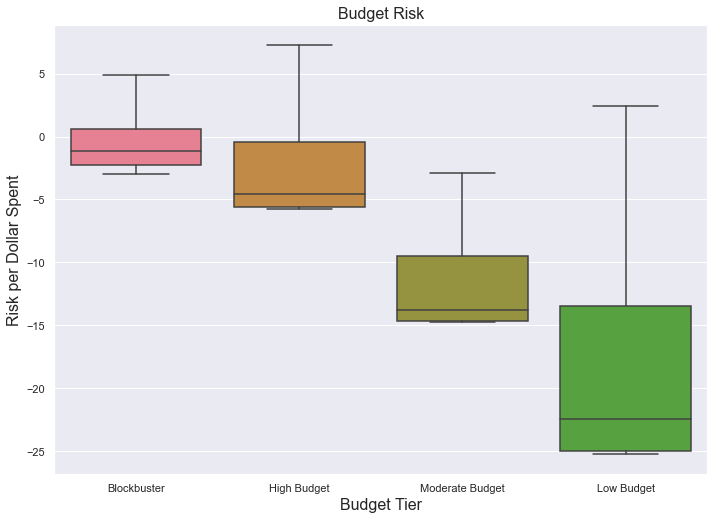

In [45]:
#plot adjusted frame with major outliers removed in order to keep graph readable
sb.boxplot(data=fullframe_adj, x='budget_tier',y="risk", showfliers = False);
plt.title('Budget Risk', fontsize=16)
plt.xlabel('Budget Tier', fontsize=16)
plt.ylabel('Risk per Dollar Spent', fontsize=16);

### Blockbusters are the safest bet!

* As it turns out, blockbusters are actually the safest bet for making money, even if they might not offer the largest ROI. With the outliers removed, our graph does not quite indicate the level of risk/reward for low budget and moderate budget films, but it gets the larger point across.

## Third Insight: There Are Trends in Which Genres of Film are More Critically Rated

* We finally get to the Rotten Tomatoes dataset! The goal here is to figure out what TYPES of movies that Microsoft should make in order to maintain a positive standing among movie goers as a studio that produces "must-see" movie events that will then generate more revenue. Inspired by the work of [Stephen Follows](https://stephenfollows.com/do-good-reviews-lead-to-financial-success/#:~:text=For%20the%20vast%20majority%20of,it%20has%20of%20becoming%20profitable) whose film industry data analysis  indicates that the profitability of some genres is directly correlated with their critical reviews.

* So first, we look to MPA rating, to see if there is any correlation between the rating its given and the how positive its reviews are. Turns out, PG-13 movies typically get the most positive ratings.

In [21]:
#create a new table of MPA reviews and ratings
mpa_review = rtmerge.groupby(['id', 'rating']).sum('critic_rating')
mpa_review.groupby('rating').mean('critic_rating').sort_values('critic_rating')

,critic_rating
rating,
NR,8
G,19
PG,27
R,36
PG-13,45


* Next we have to correlate the various genres listed in the database. Unfortunately, Rotten Tomatoes attributes multiple genre types to each film. To make sure we include every bit of possible data, we isolated the 13 major genre types and then created dataframes for each that includes every appearance of a string containing the genre name in each row.

In [22]:
#Collapse Genres to find ratings per genre
drama = rtmerge[rtmerge['genre'].str.contains('Drama')]
act = rtmerge.loc[rtmerge['genre'].str.contains('Action')]
scifi = rtmerge[rtmerge['genre'].str.contains('Science Fiction')]
com = rtmerge[rtmerge['genre'].str.contains('Comedy')]
Int = rtmerge[rtmerge['genre'].str.contains('International')]
west = rtmerge[rtmerge['genre'].str.contains('Western')]
sport = rtmerge[rtmerge['genre'].str.contains('Sport')]
rom = rtmerge[rtmerge['genre'].str.contains('Romance')]
horror = rtmerge[rtmerge['genre'].str.contains('Horror')]
mys = rtmerge[rtmerge['genre'].str.contains('Mystery')]
fam = rtmerge[rtmerge['genre'].str.contains('Family')]
musi = rtmerge[rtmerge['genre'].str.contains('Music')]
docu = rtmerge[rtmerge['genre'].str.contains('Documentary')]

* With the new frames, we can then calculate the means of each genres critic rating to see how often they are given positive reviews. We then created a new dataframe of each genre title and their average review to get a sense of which are the most popular.

In [23]:
#Find Average Rating Per Genre
drama_rating = drama['critic_rating'].mean()* 100
act_rating = act['critic_rating'].mean()* 100
scifi_rating = scifi['critic_rating'].mean()* 100
com_rating = com['critic_rating'].mean()* 100
Int_rating = com['critic_rating'].mean()* 100
sport_rating = com['critic_rating'].mean()* 100
docu_rating = com['critic_rating'].mean()* 100
west_rating = west['critic_rating'].mean()* 100
rom_rating = rom['critic_rating'].mean()* 100
horror_rating = horror['critic_rating'].mean()* 100
mys_rating = mys['critic_rating'].mean()* 100
fam_rating = fam['critic_rating'].mean()* 100
musi_rating = musi['critic_rating'].mean()* 100

#create new dataframe from Genre Critic Ratings
genre_critic = pd.DataFrame([[drama_rating, rom_rating, 
                              musi_rating, fam_rating, 
                              com_rating, Int_rating, 
                              sport_rating, docu_rating,
                              mys_rating, act_rating, 
                              west_rating, scifi_rating, 
                              horror_rating]],
                            columns=['drama','romance',
                            'musical', 'family', 'comedy', 
                            'international', 'sport', 
                            'documentary', 'mystery',  
                            'action', 'western', 
                            'science fiction', 'horror'])
genre_critic

,drama,romance,musical,family,comedy,international,sport,documentary,mystery,action,western,science fiction,horror
0,65,64,63,62,59,59,59,59,59,57,57,55,47


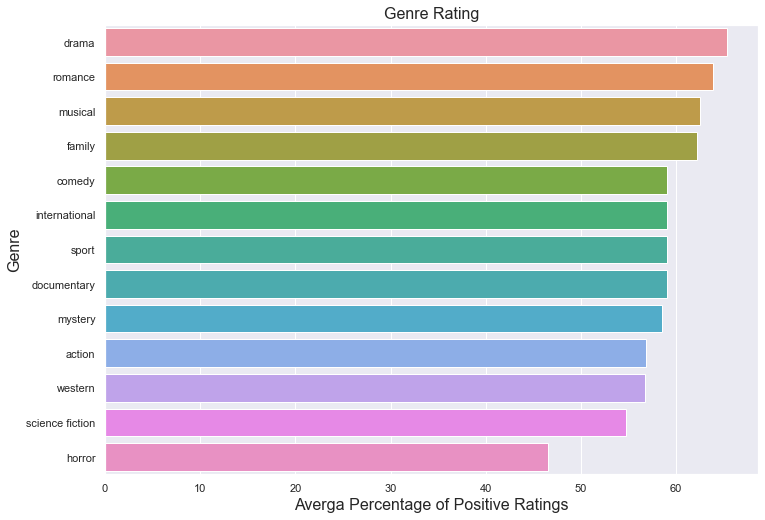

In [46]:
#plot the new frame to show most positely rated genres
sb.barplot(data=genre_critic, orient='h');
plt.title('Genre Rating', fontsize=16)
plt.xlabel('Averga Percentage of Positive Ratings', fontsize=16)
plt.ylabel('Genre', fontsize=16);

* According to our plot, the top 5 positively rated genres are drama, romance, musicals, family films, and comedies. The least positively rated movies are horror, science fiction, westerns, and action films. This strikes us as unlikely, but that could be a limitation of this dataset. This is further confirmed by the conclusions of [Stephen Follows](https://stephenfollows.com/do-good-reviews-lead-to-financial-success/#:~:text=For%20the%20vast%20majority%20of,it%20has%20of%20becoming%20profitable) film industry data analysis which indicates that the profitability of Action, Adventure, and Fantasy films are correlated with higher ratings (and Drama and Comedy are not).

# Evaluation

According to our three data insights above, it looks like if Microsoft wants to be successful in the movie industry they need to:
   1. Not be afriad to spend big on their production budgets
   2. Focus on producing primarily "blockbuster" type films while carefully taking risks with smaller budget films
   3. Produce films from genres that generate the highest positive critical reception: PG 13 and R rated films in the 
       categories of Drama, Romance, Musicals, Family, and Comedy.

# Conclusion

While we happily trust our analysis on the budget production, return on investment, and film tier, we are suspect of the conclusions involving genre. This is due to lack of data set. Given time constraints, we were not able to access a data set that connected genre, production budget, and gross income, which means we cannot actually draw any correlation between genre type, critical review, and ROI.